## Data collection

In [ ]:
!pip install gdown
!gdown --id 1SIT7Wb14P9meCiM7W1u9EaPBFlUM1A4m

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1SIT7Wb14P9meCiM7W1u9EaPBFlUM1A4m
From (redirected): https://drive.google.com/uc?id=1SIT7Wb14P9meCiM7W1u9EaPBFlUM1A4m&confirm=t&uuid=09a97e50-e057-4bd1-b6de-e27e4a16127d
To: /content/datasetKN.zip
100% 5.19G/5.19G [01:30<00:00, 57.6MB/s]


In [ ]:
import zipfile

zip_path = '/content/datasetKN.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
!ls
!cd datasetKN/
!ls

2.jpg  datasetKN  datasetKN.zip  my_model.h5  my_model.keras  sample_data
2.jpg  datasetKN  datasetKN.zip  my_model.h5  my_model.keras  sample_data


In [ ]:
!head -20 /content/datasetKN/vocab.txt

ಅ
ಅಂಕ
ಅಂಕಗಳನ್ನು
ಅಂಕಣಗಳನ್ನು
ಅಂಕಣಗಳು
ಅಂಕದ
ಅಂಕಿ
ಅಂಕಿ-ಸಂಖ್ಯೆಗಳನ್ನು
ಅಂಕಿತ
ಅಂಗಡಿ
ಅಂಗಡಿಗಳಲ್ಲಿ
ಅಂಗಡಿಪೂಜೆಗೆಂದು
ಅಂಗಡಿಯವನು
ಅಂಗನ
ಅಂಗಳ
ಅಂಗವಿಕಲ
ಅಂಗವಿಕಲರ
ಅಂಗವಿಕಲರಿಗೂ
ಅಂಗಾಂಗ
ಅಂಗೀಕರಿ


## Imports

In [ ]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [ ]:
base_path = "datasetKN"
words_list = []

words = open(f"{base_path}/fulltrain.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line.rstrip('\n'))

print(len(words_list))

np.random.shuffle(words_list)
words_list[:10]


73517


['24325 ೧೨೫ರಿಂದ',
 '60454 ಕಲಾಶಾಲೆಯ',
 '42966 ಕಥಾನಕಇತ್ತೀಚೆಗೆ',
 '3011 ಉಳಿದವರು',
 '2306 ದ್ದರೆನ್ನಲಾಗಿದೆ',
 '28046 ಸಚಿವೆ',
 '18855 ಕೆಡವಲಾಗಿದೆ',
 '52687 ವಿರೇಂದ್ರ',
 '30690 ಹರಿ',
 '65014 ಆಲೋ']

90:5:5 ratio (train:validation:test).

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 66165
Total validation samples: 3676
Total test samples: 3676


## Data input



In [ ]:
base_image_path = os.path.join(base_path, "train")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        #print(line_split)
        name = line_split[0] + ".jpg"
        label = line_split[1]
        #paths.append(name)
        paths.append(str("datasetKN/train/"+str(name)))
        #paths.append(name)
        corrected_samples.append(label)

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
print(train_img_paths[:10], train_labels[:10])
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

['datasetKN/train/24325.jpg', 'datasetKN/train/60454.jpg', 'datasetKN/train/42966.jpg', 'datasetKN/train/3011.jpg', 'datasetKN/train/2306.jpg', 'datasetKN/train/28046.jpg', 'datasetKN/train/18855.jpg', 'datasetKN/train/52687.jpg', 'datasetKN/train/30690.jpg', 'datasetKN/train/65014.jpg'] ['೧೨೫ರಿಂದ', 'ಕಲಾಶಾಲೆಯ', 'ಕಥಾನಕಇತ್ತೀಚೆಗೆ', 'ಉಳಿದವರು', 'ದ್ದರೆನ್ನಲಾಗಿದೆ', 'ಸಚಿವೆ', 'ಕೆಡವಲಾಗಿದೆ', 'ವಿರೇಂದ್ರ', 'ಹರಿ', 'ಆಲೋ']


In [ ]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    #label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))
print(characters)
# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  32
Vocab size:  83
['-', 'ಂ', 'ಃ', 'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ', 'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ', 'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ', 'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ', 'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ', 'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ', 'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ', '಼', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೠ', 'ೢ', 'ೣ', '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯']


['೧೨೫ರಿಂದ',
 'ಕಲಾಶಾಲೆಯ',
 'ಕಥಾನಕಇತ್ತೀಚೆಗೆ',
 'ಉಳಿದವರು',
 'ದ್ದರೆನ್ನಲಾಗಿದೆ',
 'ಸಚಿವೆ',
 'ಕೆಡವಲಾಗಿದೆ',
 'ವಿರೇಂದ್ರ',
 'ಹರಿ',
 'ಆಲೋ']

In [ ]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        #label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)
print(test_labels_cleaned)

['ಕೂಡಿಟ್ಟಿದ್ದ', 'ಎಫ್', 'ಹೊಲನೆ', 'ದೃಢಪಟ್ಟಿತ್ತು', 'ಜಮ್ಮು-ಕಾಶ್ಮೀರ', 'ತಳಿಗುಣವನ್ನು', 'ಪರಾಂಬರಿಸದ', 'ಹೆಚ್ಚಿನವರು', 'ತಲೆಮರೆಸಿಕೊಂಡು', 'ಕಾಮಗಾರಿ', 'ವಿಧಾನಗಳಿಂದ', 'ಸಾವಿರಾರು', 'ಕಪಿಲೇಶ್ವರ', 'ಗೌರವಿಸಿದೆ', 'ಠಾಣೆಗೆ', 'ಬ್ರಿಟನ್ನಿನಲ್ಲಿದ್ದ', 'ಲಕ್ಷ್ಮೀದೇವಿ', 'ಮುದ್ರಣ್', 'ಅರಿಯಲು', 'ಪಾಳುಬಿದ್ದಿದ್ದ', 'ಅನುಭವಗಳಿಗೆ', 'ಲೆಕ್ಕ', 'ಮಾತನಾಡುವಂತೆ', 'ಮುದ್ರಿಸಲಾಯಿತು', 'ಕುಖ್ಯಾತ', 'ಪಟಾಕಿಯೆಂಬಂತೆ', 'ಪೂರ್ಣಗೊಳಿಸಿ', 'ತೊಂದರೆಗಳೂ', 'ವತಿ', 'ಅನುಮಾನವೇ', 'ಲಾದ', 'ವಿಜೇತರಿಗೆ', 'ಗಾಬರಿಯಾದಾಗ', 'ಪಟ್ಟಿದ್ದಾರೆ', 'ಅಸೋಸಿಯೇಶನ್', 'ಮುಫ್ತಿಪಾಕಿಸ್ತಾನ', 'ಬಾಡಿ', 'ಪಂದ್ಯದಲ್ಲೂ', 'ರಂಗಪ್ರವೇಶದ', 'ಸಂತ್ರಸ್ತರಿಗೆ', 'ಅನ್ನುವ', 'ಸದೆಬಡಿಯಬೇಕಿದೆ', 'ಪ್ರಧಾನಿಯ', 'ಹಾಕಬೇಕು', 'ಏರ್ವೇಸ್', 'ಮೆಚುಕಾ', 'ಎಫ್ಐಆರ್', 'ಸೌಂದರ್ಯವನ್ನು', 'ಪಿಎಸ್ಐ', 'ಒಟ್ಟಾರೆ', 'ವರುಣ್', 'ಸ್ಟೈಲ್', 'ಮೊಟ್ಟಮೊದಲು', 'ಗೊತ್ತಿದೆಯಲ್ಲ', 'ನಿಂತಿದ್ದು', 'ಸುತ್ತುಗಳ', 'ಬಿಡುಗಡೆಯಾಯಿತು', 'ಕಂಬಳಿಯನ್ನು', 'ಸೇರಿದವರನ್ನು', 'ತುರ್ತುಸ್ಥಿತಿಯಲ್ಲಿ', 'ಸ್ಟಾಪ್', 'ಭಟ್ಟಾಕಳಂಕನ', 'ಮುದ್ದೆ', 'ತರುಣ್', 'ಮಾಡಿಲ್ಲ', 'ಇನ್ನಿಲ್ಲದಂತೆ', 'ಮುಕ್ತವಾಗಿಸುವುದು', 'ನುಡಿಗಳಿವು', 'ಅಧ್ಯಕ್ಷರಾದ', 'ಇಮ್ರಾನ್', 'ನೋಡೋದಾದ್ರೆ', 'ಕುಸಿದು', 'ಗಾಯಹಿಮಾಚಲ', 'ವಹಿವಾಟುಗರಿಷ್ಠ', 'ಬೆದೆಗೆ', 'ಬಲು', 'ವಿಯೆಟ್ನ

### Building the character vocabulary



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

### Resizing images without distortion



In [ ]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

#print(process_images_labels("datasetKN/train/1.jpg", "ಕಾಯ್ದಿರಿಸಿದ್ದ"))
print(train_img_paths[3450])

print(train_img_paths[3450])
print(train_labels_cleaned[3450])
print(vectorize_label("ಹೊಂದಿದ್ದ"))

datasetKN/train/17893.jpg
datasetKN/train/17893.jpg
ಹೊಂದಿದ್ದ
tf.Tensor(
[52 64  2 35 55 35 67 35 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99 99 99 99 99 99], shape=(32,), dtype=int64)


preparing datset... as a dataset object

---



In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


In [ ]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

೧೨೫ರಿಂದ
ಕಲಾಶಾಲೆಯ
ಕಥಾನಕಇತ್ತೀಚೆಗೆ
ಉಳಿದವರು
ದ್ದರೆನ್ನಲಾಗಿದೆ
ಸಚಿವೆ
ಕೆಡವಲಾಗಿದೆ
ವಿರೇಂದ್ರ
ಹರಿ
ಆಲೋ
ಮಾರ್ಟಿಸ್ಸಾಂಟ್
ಶುಚಿತ್ವ
ಬಾಧೆಗೊಳಗಾಗಿದ್ದು
ಪ್ರೇರೇಪಿಸಿತು
ಮಾಡುತ್ತಿರುವುದರಿಂದ
ತತ್ತರಿಸುತ್ತಿವೆ


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3303 (\N{KANNADA DIGIT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3304 (\N{KANNADA DIGIT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3307 (\N{KANNADA DIGIT FIVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3248 (\N{KANNADA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabto

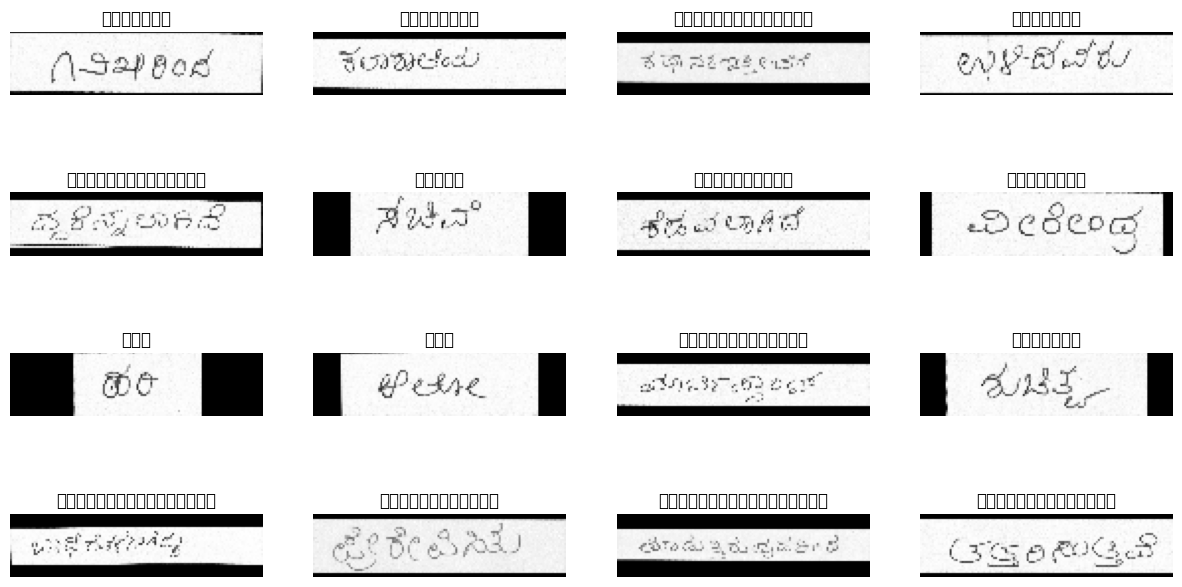

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
        print(label)

plt.show()

In [ ]:
!ls -l {train_ds.file_pattern}

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred


def build_model():
    # Input
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # conv block 1.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # conv block 2.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    #2 strides
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    #add 2 for ctc loss
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)



    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )

    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Evaluation metrics

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:
def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64 )
    # average
    edit_distances = tf.edit_distance(sparse_predictions, saprse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training



In [ ]:
epochs = 50
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/50
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 31.6354
1034/1034 [==============================] - 170s 151ms/step - loss: 30.9918 - val_loss: 29.2943
Epoch 2/50
1/1 [==============================] - 0s 38ms/step
Mean edit distance for epoch 2: 31.2410
1034/1034 [==============================] - 56s 54ms/step - loss: 27.5174 - val_loss: 25.5277
Epoch 3/50
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 3: 30.7111
1034/1034 [==============================] - 56s 55ms/step - loss: 24.6927 - val_loss: 22.8302
Epoch 4/50
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 4: 30.0969
1034/1034 [==============================] - 58s 56ms/step - loss: 22.2515 - val_loss: 20.0265
Epoch 5/50
1/1 [==============================] - 0s 23ms/step
Mean edit distance for epoch 5: 28.8511
1034/1034 [==============================] - 55s 53ms/step - loss: 19.6241 - val_loss: 16.4252
Epoch 6/50

## Inference

2/2 [==============================] - 0s 11ms/step
['ಕೊಡಿಟ್ಟಿದ್ದೆ', 'ಎಫಾ', 'ಹೊಲನೆ', 'ದೃಢಪಟ್ಟಿತ್ತು', 'ಜಮ್ಮು-ಕಕ್ಮೀಪ', 'ತಳಿಗುಣವನ್ನು', 'ಪರಾಂಬರಿಸದ', 'ಹೆಚ್ಚಿನವರು', 'ತಲೆಯಾಕಿಸಿಕೊಂಡು', 'ಕಾಮಗಾರಿ', 'ವಿಧಾನಗಳಿಂದ', 'ಸಾವಿರಾರು', 'ಕಪಿಲೇಚ್ಟರ', 'ಗಾರವಿಸಿದೆ', 'ಕಾಣೆಗೆ', 'ಇ್ರಯ್ಯಿನದರಿದ್ದ', 'ಲಕ್ಷ್ಮೀದೇವಿ', 'ಮುದ್ರಣ್', 'ಅರಿಯಲು', 'ಪಾಳುಬಿದ್ದಿದ್ದ', 'ಅನುಭವಗಳಿಗೆ', 'ಲೆಕ್ಕ', 'ಮಾತನಾಡುವಂತೆ', 'ಮುದ್ತಿದಲಾಯಿತು', 'ಕುಖ್ಯಾತ', 'ಹಣಿಕೆಯಯಂತ', 'ಮಾರ್ಗಿಗೊಳಳಿ', 'ತೊಂದರೆಗಳೂ', 'ವತಿ', 'ಅರುದಾನತೇ', 'ಲಾದ', 'ವಿಡೇಳರಿಗೆ', 'ಗಾಬರಿಯಾದಾಗ', 'ಪಟ್ಟಿದ್ದಾರೆ', 'ಆಸೋಸಿಯೋಕನ್', 'ಮುಖ್ರಪಾಕಗಾಗ', 'ಬಾದಿ', 'ಪಂಧ್ರದಲ್ಲಿ', 'ರಂಗಪ್ರವೇಶದ', 'ಸಂತ್ರಸ್ತರಿಗೆ', 'ಅನ್ನುವ', 'ನವೆಂನಾಯಬೇಕಿದೆ', 'ಪ್ರಧಾನಿಯ', 'ಹಾಕಬೇಕು', 'ವಿರ್ವೇಸ್', 'ಮುಹುಕಾ', 'ಎಘೆಬಡರ್', 'ಕೌಂದರ್ಯವನ್ನು', 'ಪಿಎಸೌಬ', 'ಒಟ್ಟಾರ್', 'ವರುಣ್', 'ಸ್ೈರಲ್', 'ಮೊಜ್ಟಮೊಡಲು', 'ಗೊತ್ತಿದೆಯಲ್ಲಿ', 'ಹಿಂತಿದ್ದು', 'ಸುತ್ತಗಳ', 'ಬಡುಗಡೆಯಾಯಿತು', 'ಕಂಬಳಿಯನ್ನು', 'ಸೇಡಿದವರನ್ನು', 'ತುರ್ತನ್ಗಿತಿಯಲ್ಲಿ', 'ಸ್ಥಾಪ್', 'ಭಟ್ಟಾಕಳಂಕನ', 'ಮುದದ್ಥೆ', 'ತರುಸ್']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3228 (\N{KANNADA LETTER JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3235 (\N{KANNADA LETTER NNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


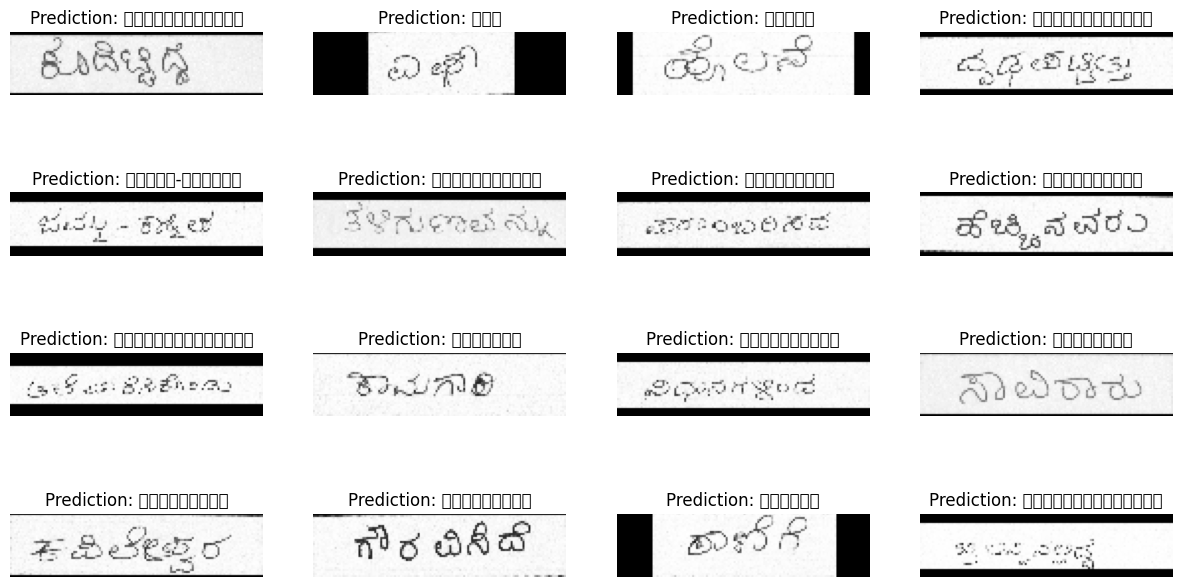

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        plt.rc('axes', unicode_minus=False)

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import tensorflow as tf


# model = tf.keras.models.load_model('my_model.h5')

# model.summary()


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow import keras


model = tf.keras.models.load_model('my_model.keras')

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]


    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:32]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def preprocess_image(image_path, img_size=(128, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = tf.image.rgb_to_grayscale(image)
    image = distortion_free_resize(image, (128, 32))
    image = tf.cast(image, tf.float32) / 255.0
    return image

image_path = '/content/1.jpg'
img = preprocess_image(image_path)
img = np.expand_dims(img, axis=0)
#print(img)
# predictions
predictions = model.predict(img)
text = decode_batch_predictions(predictions)
print(text)



1/1 [==============================] - 2s 2s/step
['ಚರಮರಿ']
